## 정상성 검정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 불러오기
sero_data = pd.read_csv("./data/sero_data.csv")

# 모델 생성
# RandomForestRegressor

# 2018 년도 데이터 빼기
data_2018 = sero_data[-2191:]
sero_data = sero_data[:-2191]

In [13]:
# 결측치가 있는 칼럼 추출
isna_bool = list(data_2018.isna().iloc[0,:].values)
na_columns = data_2018.columns[isna_bool]

In [14]:
na_columns

Index(['ACT', 'ACMTC', 'ACMTP', 'ACMTR', 'ACMTS', 'CFOA', 'CSI', 'CBIT',
       'CAGR', 'D', 'DIA', 'DTA', 'IA', 'IG', 'L', 'LTB', 'NI', 'NOCT', 'S',
       'SMC', 'STB', 'TFAG', 'TA', 'TAT'],
      dtype='object')

## 정상성
- 해당 시계열이 관측된 시간에 무관한 것
- 평균과 분산이 안정되어 있음
    - 평균이 일정하지 않으면 => 차분
        - 차분 : 임의 두 점에서의 관측값의 차이(미분의 이산적인 표현)
    - 분산이 일정하지 않으면 => 변환
        - ex) 로그변환
- 추세, 계절성이 없어야 함
- 주기성 행동(추세나 계절성은 없는)을 가지고 있더라도 주기가 불규칙적이라면 정상성을 나타내는 시계열
     - 주기의 고점이나 저점이 어디인지 확실하게 알 수 없기 때문

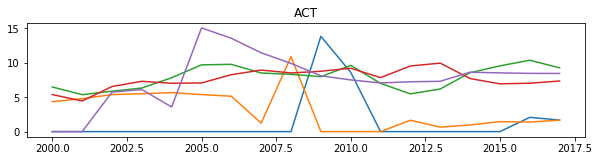

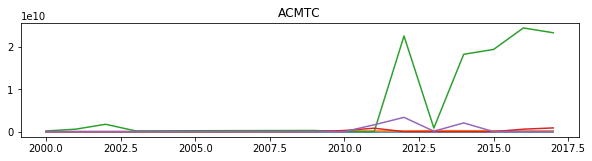

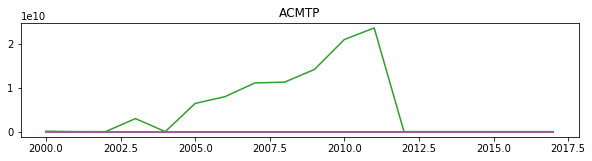

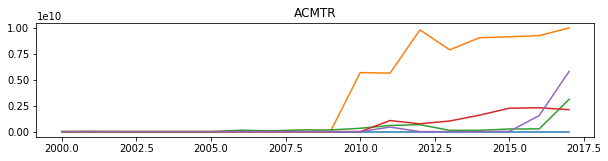

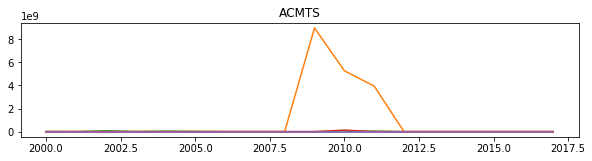

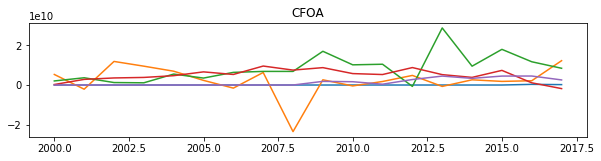

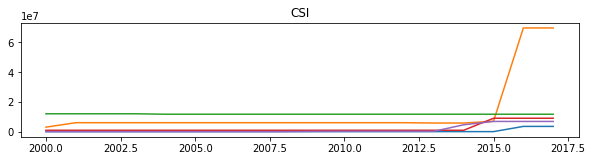

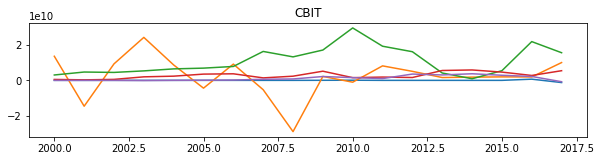

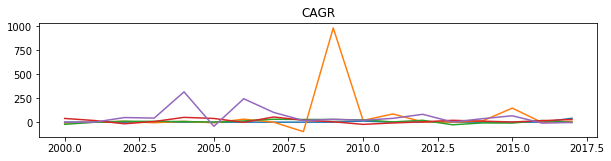

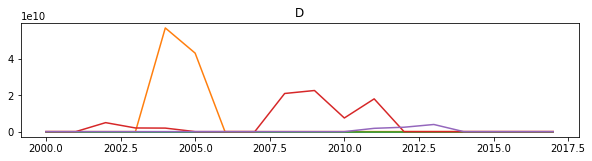

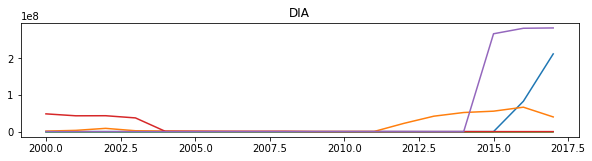

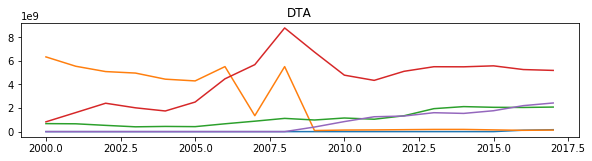

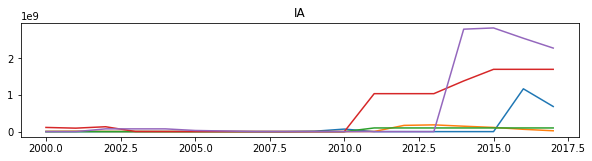

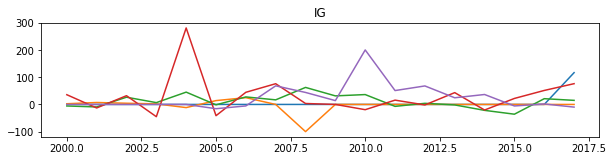

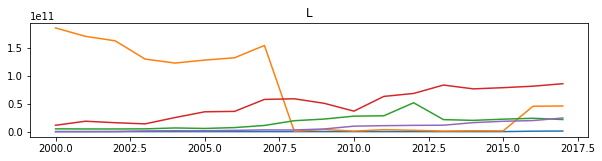

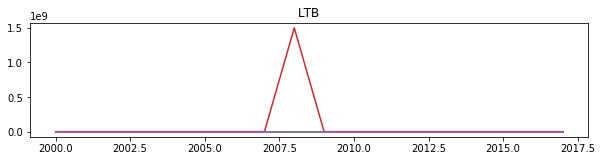

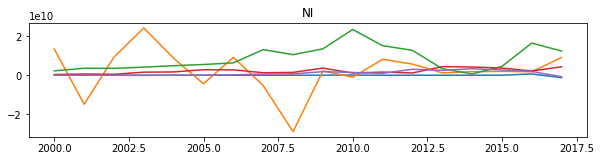

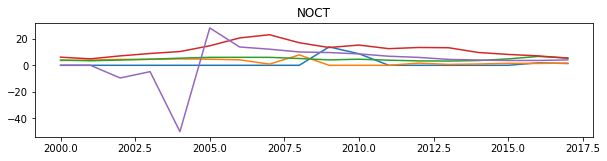

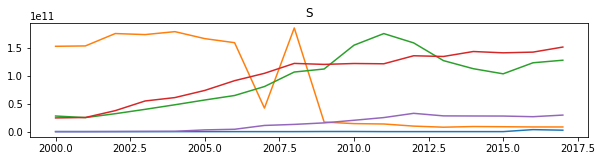

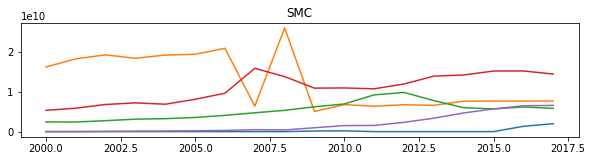

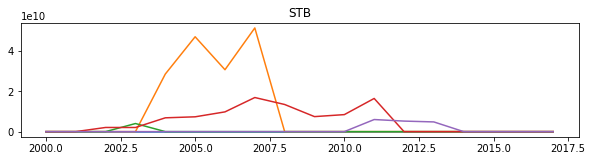

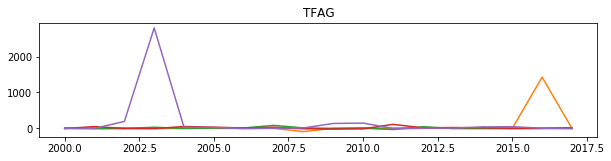

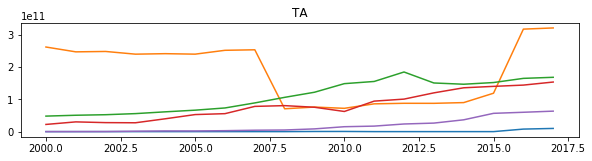

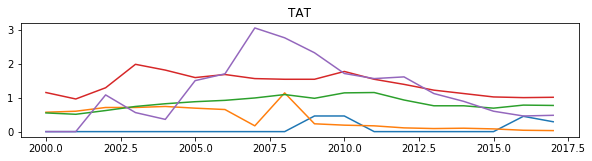

In [82]:
# 시각화로 정상성 확인
n = len(na_columns)
for col_idx in range(len(na_columns)):
    plt.figure(figsize=(10,60))
    plt.subplot(len(na_columns), 1,col_idx+1)
    
    # random 으로 5개 기업 추출
    sub_data = np.random.choice(2191,5)
    for i in sub_data:
        # 5개 기업의 해당 칼럼의 년도별 데이터 추출
        a = sero_data.loc[range(i,sero_data.shape[0],2191), na_columns[col_idx]]
        a.index = range(2000,2018)
        
        plt.plot(a)
        plt.title(na_columns[col_idx])
        
    plt.show()
    
# 추세가 없는 것으로 보이는 LTB, NOCT, STB, TFAG -> 나머지 칼럼은 추세가 있는 것으로 확인됨
# but 대부분 정상성 없을 것으로 추정..

### 비정상성 데이터 -> 정상성 데이터
#### 확률보행 모델
- 1차 차분해서 정상성을 나타내는 시계열 얻은 후 사용
- 평균이 일정하지 않아 정상성을 가지지 않는 데이터는 "차분"함으로써 정상성을 띄게 해줄 수 있음
- 뚜렷한 추세에 있는 데이터라면 차분값이 어떠한 평균값(c)을 가질 것임.
    - c가 양수이면 위쪽방향으로 이동하는 경향
    - c가 음수이면 아래쪽방향으로 이동하는 경향
    
#### 2차 차분
- 차분으로 구한 데이터가 정상성을 띄지 않는다면, 정상성을 나타내는 시계열을 얻기 위하여 2번 차분
    - "변화에 대한 변화"를 모델링

#### 계절성 차분(시차 m차분)
- 관측치와 같은 계절의 이전 관측값의 차이
- m주기 시차 뒤의 관측을 뺌
- 계절성 차분과 1차 차분을 둘 다 적용할 수 있지만, 계절성 차분 먼저하는 것이 좋음
    - yt = (yt-yt-m)-(yt-1-yt-1-m)

## 정상성 검증
#### 단위근 검정
1. DF 단위근 검정
    - 적분차수가 1차인 경우를 가정(1차 차분으로 정상성을 띄는 데이터가 될 것이다.) 
    - yt = yt-1+error term
        - error term : 평균 0, 분산이 x인 자기상관이 없는 무작위성
    - 귀무가설 : 1차 적분한 데이터이다.(정상성을 띄지 않는다)
    - 대립가설 : 1차 적분하지 않은 데이터이다.(정상성을 띄는 데이터이다.)

2. ADF 검정
    - 적분차수를 1차적분에서 2차적분까지 가능하도록 DF 검정을 일반화한 것.

In [38]:
 from statsmodels.tsa.stattools import adfuller

In [15]:
na_columns

Index(['ACT', 'ACMTC', 'ACMTP', 'ACMTR', 'ACMTS', 'CFOA', 'CSI', 'CBIT',
       'CAGR', 'D', 'DIA', 'DTA', 'IA', 'IG', 'L', 'LTB', 'NI', 'NOCT', 'S',
       'SMC', 'STB', 'TFAG', 'TA', 'TAT'],
      dtype='object')

In [80]:
all_p_value = pd.DataFrame([])
for col in na_columns:
    for i in range(0,2191):
        a = sero_data.loc[range(i,sero_data.shape[0],2191), col]
        p_value = adfuller(a)[1]
        if not i:
            all_p_value[col]=p_value
        else:
            all_p_value = pd.concat([all_p_value,pd.DataFrame([p_value], columns=[col])], axis=0)


### 정상성을 띄는 데이터
- 'ACMTS' : 관계회사 상호거래 매입
- 'D' : 감가상각비
- 'IG' : 재고자산증가율
- 'LTB' : 장기차입금
- 'NI' : 순영업자본대매출
- 'NOCT' : 유형 고정 자산증가율
- 'TFAG' : 유형 고정 자산증가율

In [96]:
all_p_value.columns[all_p_value.mean(axis=0)<=0.05]

Index(['ACMTS', 'D', 'IG', 'LTB', 'NI', 'NOCT', 'TFAG'], dtype='object')